In [131]:
%matplotlib inline

### Wczytanie niezbędnych bibliotek

In [543]:
import re
import time

import numpy as np
import pandas as pd
import nltk
import gensim

import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

from pyMorfologik import Morfologik
from pyMorfologik.parsing import ListParser

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Conv1D, Flatten, Dropout, Dense, LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils

### Definicja klasy procesującej dokumenty.

In [172]:
class TokenizedDataFrame():
    __slots__ = ['stopwords', 'stemmed_dict']
    
    def __init__(self, stopwords):
        self.stopwords = stopwords
        self.stemmed_dict = None
        
    
    def prepare_text(self, doc):
        doc = re.sub(r'[^\w\s]','',doc)
        doc = doc.lower()
        doc = nltk.word_tokenize(doc)
        doc = [word for word in doc if word not in self.stopwords]
        return doc
    
    
    def apply_stemming(self, df):
        all_words = list()

        for item in list(df):
            all_words.extend(item)
    
        unique_words = list(set(all_words))
        
        self.stemmed_dict = dict()
        unique_words_stemmer = stemmer.stem(unique_words, parser)

        for item in unique_words_stemmer:
            original = item[0]
            try:
                stemmed = list(item[1])[0]
                self.stemmed_dict[original] = stemmed
            except IndexError:
                self.stemmed_dict[original] = stemmed
        
        
        missings = {item:item for item in unique_words if item not in self.stemmed_dict.keys()}
        self.stemmed_dict.update(missings)
        
        
    @staticmethod
    def remove_empty(df, col):
        return df.loc[df[col].apply(lambda x: len(x)) > 0, :]
    
       
    def transform(self, X, col, **kwargs):
        try:
            X_local = X.copy()
            X_local[col] = X_local[col].apply(self.prepare_text)
            X_local = self.remove_empty(X_local, col)
        except KeyError:
            raise KeyError("{} not present in dataframe".format(col))
            
        if not self.stemmed_dict:
            self.apply_stemming(X_local[col])
            
        X_local[col] = X_local[col].apply(lambda doc: list(map(self.stemmed_dict.get, doc)))
        X_local = X_local.reset_index(drop=True)
        
        return X_local

### Zdefiniowanie stałych

In [496]:
DATA_PATH = './data/learning_set.csv'
STOPWORDS_PATH = 'data/polish_stopwords.csv'
W2V_PATH = 'data/nkjp+wiki-forms-all-100-cbow-hs.txt'

RANDOM_STATE = 23032019

C_V = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

SCORING = 'accuracy'
N_JOBS = -1

### Wczytanie dokumentów

In [497]:
df = pd.read_csv(DATA_PATH, sep = ';')

In [498]:
df.groupby('sentiment').count()/df.shape[0]

,token
sentiment,
-1,0.102936
0,0.762434
1,0.134629


In [500]:
stopwords = list(pd.read_csv(STOPWORDS_PATH, engine='python', header=None).iloc[:, 0])

parser = ListParser()
stemmer = Morfologik()

df = TokenizedDataFrame(stopwords).transform(df, 'token')

### Podział na zbiór treningowy/testowy

#### y_train/y_test używamy do sklearn API, dummy do Kerasa

In [517]:
x_train, x_test, y_train, y_test = train_test_split(df.token, 
                                                    df.sentiment, 
                                                    test_size=0.15, 
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

In [520]:
model_lr = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', tokenizer=lambda x: x,
                              preprocessor=lambda x: x, ngram_range=(1,2),
                              sublinear_tf=True)),
    ('lr', LogisticRegression(penalty='l2', random_state=RANDOM_STATE,
                              n_jobs=-1, multi_class='multinomial', solver='lbfgs')
                             )
])

model_lr.fit(x_train, y_train)


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<function <lam...ty='l2', random_state=23032019, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

### Ile wynosi null accuracy?

In [537]:
print("{:.1f}%".format(100*y_train.value_counts().max()/len(y_train)))

66.9%


### Jakie accuracy na 10-krotnej CV osiąga regresja logistyczna?

In [538]:
cross_validate(model_lr, 
               x_train,
               y_train,
               cv=C_V,
               scoring=SCORING,
               n_jobs=N_JOBS, 
               return_train_score=True)\
.get('test_score')\
.mean()

0.753936106166442

### Accuracy na zbiorze testowym

In [540]:
accuracy_score(y_test, model_lr.predict(x_test))

0.7587994542974079

### Wykres krzywej uczenia

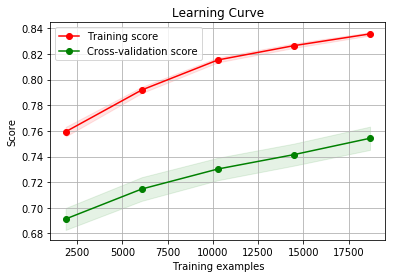

In [541]:
skplt.estimators.plot_learning_curve(model_lr,
                                     x_train,
                                     y_train,
                                     cv=C_V,
                                    random_state=RANDOM_STATE,
                                    n_jobs=N_JOBS,
                                    scoring=SCORING)
plt.show()

### Wykres słów najbardziej stymulujących skrajny sentyment według regresji

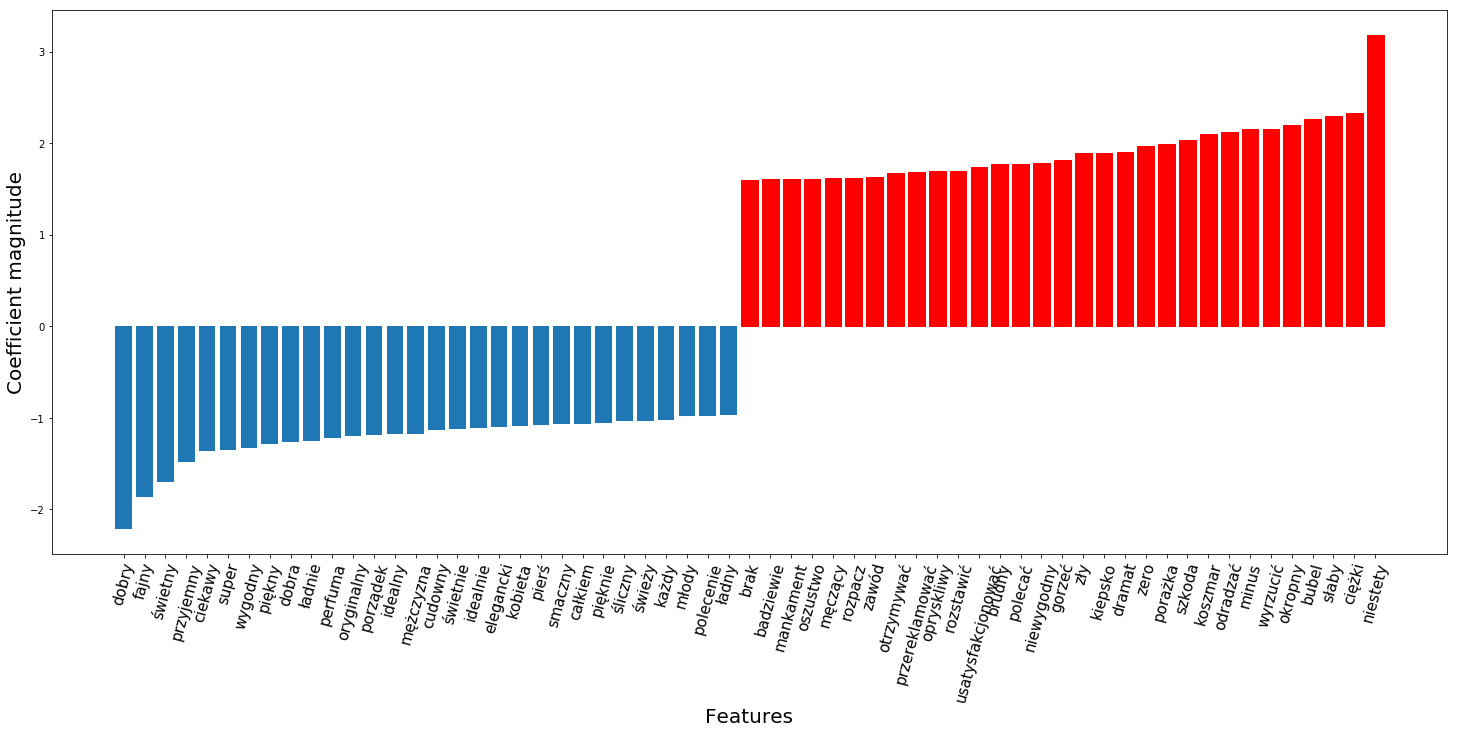

In [553]:
coefficients = model_lr.named_steps.get('lr').coef_
index = coefficients.argsort()

feature_names = np.array(model_lr.named_steps.get('tfidf').get_feature_names())
feature_names_comb = list(feature_names[index][0][:30]) + list(feature_names[index][0][-31::1])

index_comb = list(coefficients[0][index[0][:30]]) + list(coefficients[0][index[0][-31::1]])

plt.figure(figsize=(25,10))
barlist = plt.bar(list(i for i in range(61)), index_comb)
plt.xticks(list(i for i in range(61)),feature_names_comb,rotation=75,size=15)
plt.ylabel('Coefficient magnitude',size=20)
plt.xlabel('Features',size=20)

# color the first smallest 30 bars red
for i in range(30, 61):
    barlist[i].set_color('red')

plt.show()

### Zdefiniowanie funkcji wczytującej embeddingi, klasy procesującej dane do sieci neuronowej i samej sieci.

In [563]:
def non_trivial_sentence(sentence):
    len_words = [True if len(i) > 1 else 0 for i in sentence]
    return any(len_words)

def init(embeddings_type = 'w2v'): # function to load word embedding only once 
    if embeddings_type == 'w2v':    
        global w2vModel
        w2vModel = load_w2v_embeddings(W2V_PATH)
    else:
        raise NameError('Invalid embedding type {}'.format(embeddings_type))
        
def get_embeddings(embeddings_type = 'w2v'):
    if embeddings_type == 'w2v':
        global w2vModel
        try:
            return w2vModel
        except NameError:
            init(embeddings_type)
            return w2vModel
    else:
        raise NameError('Invalid embedding type %s' % embeddings_type)

def load_w2v_embeddings(path):
    w2vModel = gensim.models.KeyedVectors.load_word2vec_format(path, 
                                                               binary=False)
    return w2vModel 

class FixedSizeArray(BaseEstimator, TransformerMixin): # Transformer for transforming given data into undersoodable form for neural network
    def __init__(self, dimensions, steps, word2vec_mod=None):
        self.dim = dimensions
        self.steps = steps
        self.w2v = word2vec_mod
        
    def fit_transform(self, texts, y=None):
        return self.transform(texts, y)
    
    def fit(self, texts):
        return None
    
    def _transform(self, article):
        #tokens = CountVectorizer().build_tokenizer()(article) 
        doc_vectors_gen = (self.w2v[a].tolist() for a in article if a in self.w2v.vocab)
        doc_vectors = [a for (i, a) in enumerate(doc_vectors_gen) if i < self.steps]
        
        while len(doc_vectors) < self.steps:
            doc_vectors.append([0])
    
        pad_vectors = pad_sequences(doc_vectors,padding='post',dtype='float32', maxlen=self.dim, value=0.)
        return pad_vectors
    
    def transform(self, sentences, y=None):
        
        if self.w2v == None:
            print("Lazy loading embeddings...")
            self.w2v = get_embeddings('w2v')
        
        #sentences = [eval(i) for i in sentences]
        return np.array([self._transform(i) for i in sentences])
    
    
def plot_training(history): # plot training history
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
def create_conv_model(dropout, input_shape, kernel_size=3): 
    model = Sequential()
    model.add(Conv1D(64, kernel_size, input_shape=(input_shape, 100), padding='same'))
    model.add(Conv1D(32, kernel_size, padding='same'))
    model.add(Conv1D(16, kernel_size, padding='same'))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(180, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    return model

def create_simple_LSTM_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape = (10, 100), return_sequences=True))
    model.add(SpatialDropout1D(0.5))
    model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(3,activation='softmax'))
    return model

def create_LSTM_model(input_shape):
    model = Sequential()
    model.add(LSTM(256, input_shape = (input_shape, 100), return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model

class NeuralNet(BaseEstimator, ClassifierMixin): 
    
    def __init__(self, model, name='', validation_size=0.2, batchsize = 256, epochs = 10):
        self.model = model
        self.model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
        self.early_stopping = EarlyStopping(patience=2) # early stopping callback
        self.checkpointer = ModelCheckpoint(filepath='{}_{}.h5'.format(name,
                                                                       time.time()), 
                                            verbose=1, 
                                            save_best_only=True) # save the best model
        self.tensorboard = TensorBoard(log_dir="logs/{}-{}".format(name,time.time())) # show results in the tensorboard
        self.batchsize = batchsize
        self.epochs = epochs
        self.validation_size = validation_size
        
    def fit(self, X, y):
        
        history = self.model.fit(X, 
                                 y, 
                                 validation_split=self.validation_size, 
                                 batch_size=self.batchsize, 
                                 epochs=self.epochs, 
                                 callbacks=[self.checkpointer, 
                                            self.early_stopping, 
                                            self.tensorboard] if self.validation_size != 0
                                else [self.checkpointer, self.tensorboard])
        self.history = history
        
    def predict(self, X):
        return self.model.predict(X)

In [559]:
def get_accuracy_score(estimator):
    pred = estimator.predict(x_test).argmax(axis=1)-1
    return accuracy_score(y_test, pred)

### Prosty LSTM

Lazy loading embeddings...
Train on 16613 samples, validate on 4154 samples
Epoch 1/10
16613/16613 [==============================] - ETA: 2:08 - loss: 0.6378 - acc: 0.668 - ETA: 1:07 - loss: 0.6361 - acc: 0.667 - ETA: 47s - loss: 0.6317 - acc: 0.666 - ETA: 36s - loss: 0.6286 - acc: 0.66 - ETA: 30s - loss: 0.6243 - acc: 0.66 - ETA: 25s - loss: 0.6202 - acc: 0.66 - ETA: 23s - loss: 0.6144 - acc: 0.66 - ETA: 20s - loss: 0.6098 - acc: 0.66 - ETA: 18s - loss: 0.6045 - acc: 0.66 - ETA: 17s - loss: 0.5995 - acc: 0.67 - ETA: 15s - loss: 0.5941 - acc: 0.67 - ETA: 14s - loss: 0.5899 - acc: 0.68 - ETA: 14s - loss: 0.5856 - acc: 0.68 - ETA: 13s - loss: 0.5809 - acc: 0.69 - ETA: 12s - loss: 0.5750 - acc: 0.70 - ETA: 11s - loss: 0.5736 - acc: 0.70 - ETA: 11s - loss: 0.5688 - acc: 0.70 - ETA: 10s - loss: 0.5634 - acc: 0.71 - ETA: 10s - loss: 0.5597 - acc: 0.71 - ETA: 9s - loss: 0.5559 - acc: 0.7206 - ETA: 9s - loss: 0.5520 - acc: 0.724 - ETA: 8s - loss: 0.5475 - acc: 0.727 - ETA: 8s - loss: 0.5441 -

16613/16613 [==============================] - ETA: 7s - loss: 0.3553 - acc: 0.843 - ETA: 7s - loss: 0.3375 - acc: 0.850 - ETA: 8s - loss: 0.3237 - acc: 0.854 - ETA: 7s - loss: 0.3292 - acc: 0.854 - ETA: 7s - loss: 0.3360 - acc: 0.852 - ETA: 7s - loss: 0.3205 - acc: 0.862 - ETA: 7s - loss: 0.3193 - acc: 0.863 - ETA: 7s - loss: 0.3133 - acc: 0.863 - ETA: 7s - loss: 0.3071 - acc: 0.864 - ETA: 7s - loss: 0.3063 - acc: 0.865 - ETA: 7s - loss: 0.3065 - acc: 0.864 - ETA: 7s - loss: 0.3084 - acc: 0.862 - ETA: 6s - loss: 0.3126 - acc: 0.859 - ETA: 6s - loss: 0.3134 - acc: 0.858 - ETA: 6s - loss: 0.3149 - acc: 0.856 - ETA: 6s - loss: 0.3138 - acc: 0.856 - ETA: 6s - loss: 0.3142 - acc: 0.856 - ETA: 6s - loss: 0.3119 - acc: 0.858 - ETA: 6s - loss: 0.3113 - acc: 0.857 - ETA: 6s - loss: 0.3109 - acc: 0.857 - ETA: 5s - loss: 0.3145 - acc: 0.856 - ETA: 5s - loss: 0.3123 - acc: 0.857 - ETA: 5s - loss: 0.3114 - acc: 0.857 - ETA: 5s - loss: 0.3106 - acc: 0.857 - ETA: 5s - loss: 0.3087 - acc: 0.857 - ETA

16613/16613 [==============================] - ETA: 7s - loss: 0.2787 - acc: 0.876 - ETA: 7s - loss: 0.2707 - acc: 0.885 - ETA: 8s - loss: 0.2787 - acc: 0.876 - ETA: 8s - loss: 0.2645 - acc: 0.884 - ETA: 8s - loss: 0.2638 - acc: 0.883 - ETA: 8s - loss: 0.2630 - acc: 0.884 - ETA: 8s - loss: 0.2706 - acc: 0.880 - ETA: 7s - loss: 0.2683 - acc: 0.882 - ETA: 7s - loss: 0.2663 - acc: 0.884 - ETA: 7s - loss: 0.2667 - acc: 0.885 - ETA: 7s - loss: 0.2595 - acc: 0.889 - ETA: 7s - loss: 0.2603 - acc: 0.890 - ETA: 7s - loss: 0.2603 - acc: 0.889 - ETA: 6s - loss: 0.2575 - acc: 0.890 - ETA: 6s - loss: 0.2562 - acc: 0.890 - ETA: 6s - loss: 0.2568 - acc: 0.889 - ETA: 6s - loss: 0.2565 - acc: 0.890 - ETA: 6s - loss: 0.2565 - acc: 0.890 - ETA: 6s - loss: 0.2569 - acc: 0.889 - ETA: 6s - loss: 0.2562 - acc: 0.890 - ETA: 5s - loss: 0.2555 - acc: 0.890 - ETA: 5s - loss: 0.2532 - acc: 0.891 - ETA: 5s - loss: 0.2530 - acc: 0.891 - ETA: 5s - loss: 0.2534 - acc: 0.891 - ETA: 5s - loss: 0.2532 - acc: 0.891 - ETA

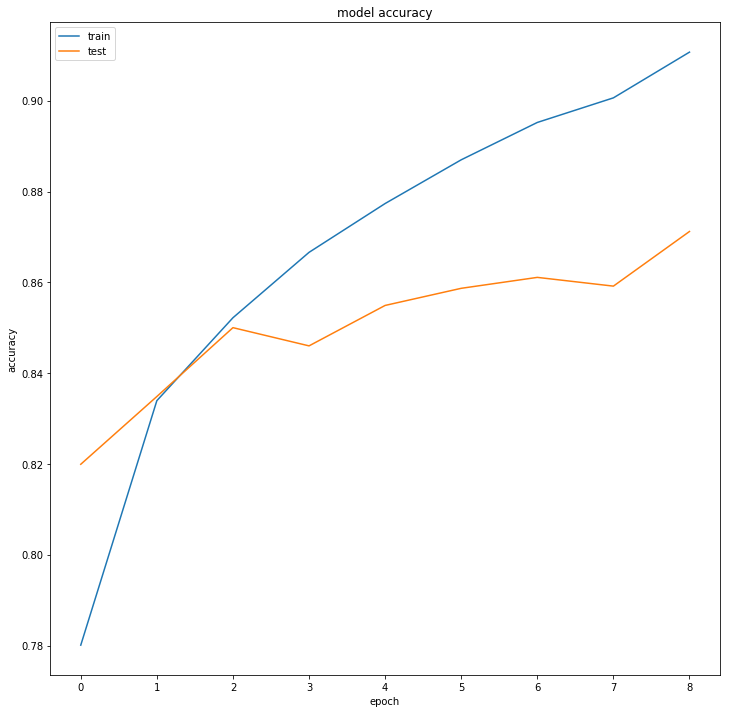

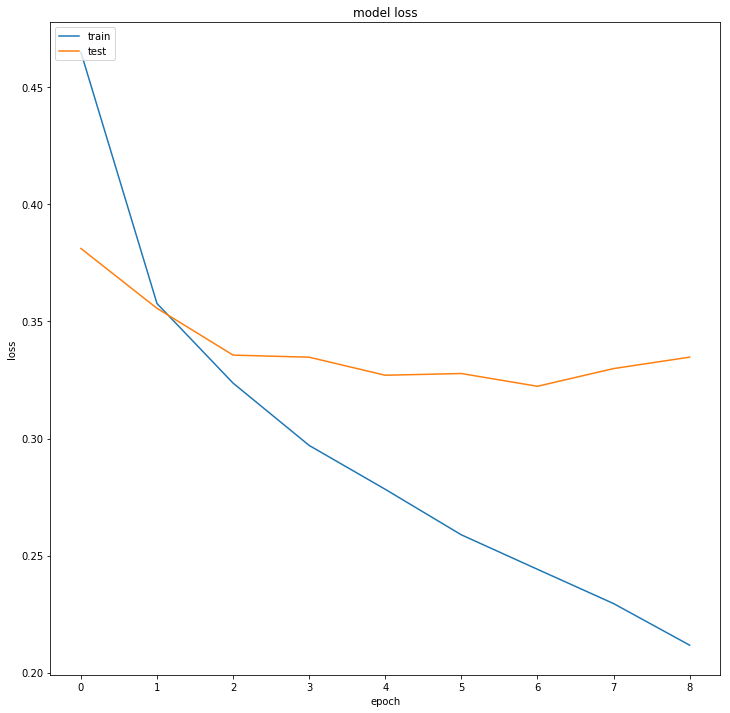

In [546]:
model_simple_lstm = Pipeline([
    ('fsa', FixedSizeArray(100,10)),
    ('nn', NeuralNet(create_simple_LSTM_model(10), 'simple_LSTM')),
])  # written classes can be used with sklearn Pipeline class

model_simple_lstm.fit(x_train, dummy_y_train)

plot_training(model.steps[1][1].history) 

In [560]:
get_accuracy_score(model_simple_lstm)

0.791268758526603

### LSTM

Lazy loading embeddings...
Train on 16613 samples, validate on 4154 samples
Epoch 1/10
16613/16613 [==============================] - ETA: 2:51 - loss: 0.6396 - acc: 0.666 - ETA: 1:36 - loss: 0.6323 - acc: 0.666 - ETA: 1:09 - loss: 0.6233 - acc: 0.667 - ETA: 56s - loss: 0.6159 - acc: 0.665 - ETA: 47s - loss: 0.6113 - acc: 0.66 - ETA: 42s - loss: 0.6054 - acc: 0.66 - ETA: 38s - loss: 0.6012 - acc: 0.67 - ETA: 35s - loss: 0.5910 - acc: 0.68 - ETA: 32s - loss: 0.5833 - acc: 0.69 - ETA: 30s - loss: 0.5820 - acc: 0.69 - ETA: 29s - loss: 0.5750 - acc: 0.70 - ETA: 27s - loss: 0.5678 - acc: 0.70 - ETA: 26s - loss: 0.5601 - acc: 0.71 - ETA: 25s - loss: 0.5560 - acc: 0.72 - ETA: 24s - loss: 0.5532 - acc: 0.72 - ETA: 23s - loss: 0.5483 - acc: 0.72 - ETA: 23s - loss: 0.5440 - acc: 0.72 - ETA: 22s - loss: 0.5390 - acc: 0.73 - ETA: 21s - loss: 0.5341 - acc: 0.73 - ETA: 20s - loss: 0.5283 - acc: 0.73 - ETA: 19s - loss: 0.5226 - acc: 0.74 - ETA: 19s - loss: 0.5175 - acc: 0.74 - ETA: 18s - loss: 0.5135

16613/16613 [==============================] - ETA: 25s - loss: 0.3235 - acc: 0.84 - ETA: 25s - loss: 0.3138 - acc: 0.85 - ETA: 24s - loss: 0.3039 - acc: 0.86 - ETA: 23s - loss: 0.2944 - acc: 0.86 - ETA: 23s - loss: 0.2954 - acc: 0.86 - ETA: 23s - loss: 0.2981 - acc: 0.86 - ETA: 24s - loss: 0.3045 - acc: 0.85 - ETA: 24s - loss: 0.3127 - acc: 0.85 - ETA: 23s - loss: 0.3091 - acc: 0.85 - ETA: 23s - loss: 0.3124 - acc: 0.85 - ETA: 23s - loss: 0.3096 - acc: 0.86 - ETA: 24s - loss: 0.3099 - acc: 0.86 - ETA: 24s - loss: 0.3123 - acc: 0.85 - ETA: 23s - loss: 0.3120 - acc: 0.85 - ETA: 23s - loss: 0.3139 - acc: 0.85 - ETA: 23s - loss: 0.3145 - acc: 0.85 - ETA: 22s - loss: 0.3157 - acc: 0.85 - ETA: 21s - loss: 0.3139 - acc: 0.85 - ETA: 21s - loss: 0.3126 - acc: 0.85 - ETA: 21s - loss: 0.3103 - acc: 0.85 - ETA: 20s - loss: 0.3084 - acc: 0.86 - ETA: 19s - loss: 0.3082 - acc: 0.86 - ETA: 19s - loss: 0.3062 - acc: 0.86 - ETA: 19s - loss: 0.3075 - acc: 0.86 - ETA: 18s - loss: 0.3093 - acc: 0.85 - ETA

16613/16613 [==============================] - ETA: 26s - loss: 0.2449 - acc: 0.89 - ETA: 26s - loss: 0.2559 - acc: 0.89 - ETA: 25s - loss: 0.2683 - acc: 0.89 - ETA: 25s - loss: 0.2565 - acc: 0.89 - ETA: 25s - loss: 0.2577 - acc: 0.89 - ETA: 25s - loss: 0.2567 - acc: 0.89 - ETA: 25s - loss: 0.2584 - acc: 0.88 - ETA: 25s - loss: 0.2612 - acc: 0.88 - ETA: 26s - loss: 0.2563 - acc: 0.88 - ETA: 25s - loss: 0.2566 - acc: 0.88 - ETA: 25s - loss: 0.2608 - acc: 0.88 - ETA: 24s - loss: 0.2591 - acc: 0.88 - ETA: 24s - loss: 0.2607 - acc: 0.88 - ETA: 23s - loss: 0.2598 - acc: 0.88 - ETA: 23s - loss: 0.2594 - acc: 0.88 - ETA: 22s - loss: 0.2600 - acc: 0.88 - ETA: 22s - loss: 0.2601 - acc: 0.88 - ETA: 21s - loss: 0.2611 - acc: 0.88 - ETA: 20s - loss: 0.2609 - acc: 0.88 - ETA: 20s - loss: 0.2612 - acc: 0.88 - ETA: 20s - loss: 0.2617 - acc: 0.88 - ETA: 19s - loss: 0.2630 - acc: 0.88 - ETA: 19s - loss: 0.2607 - acc: 0.88 - ETA: 18s - loss: 0.2584 - acc: 0.88 - ETA: 18s - loss: 0.2585 - acc: 0.88 - ETA

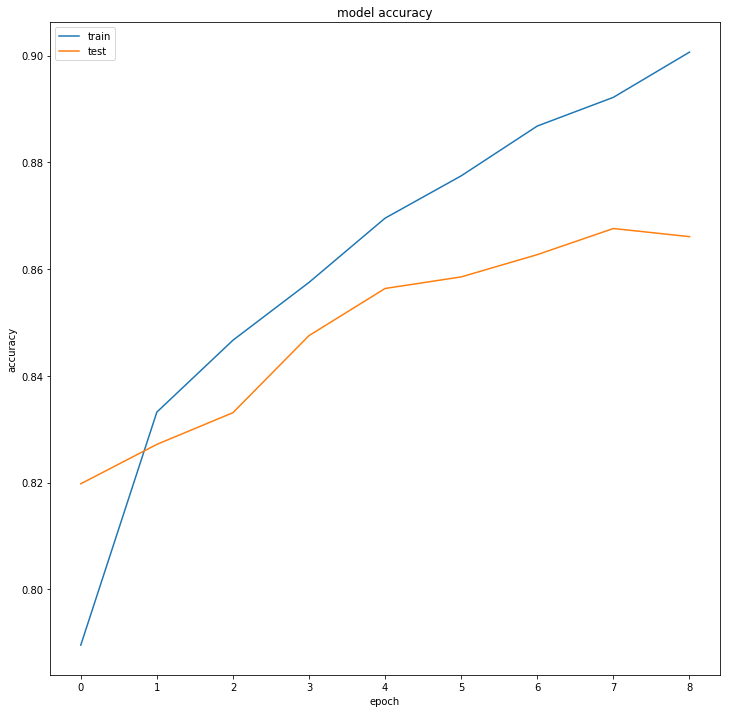

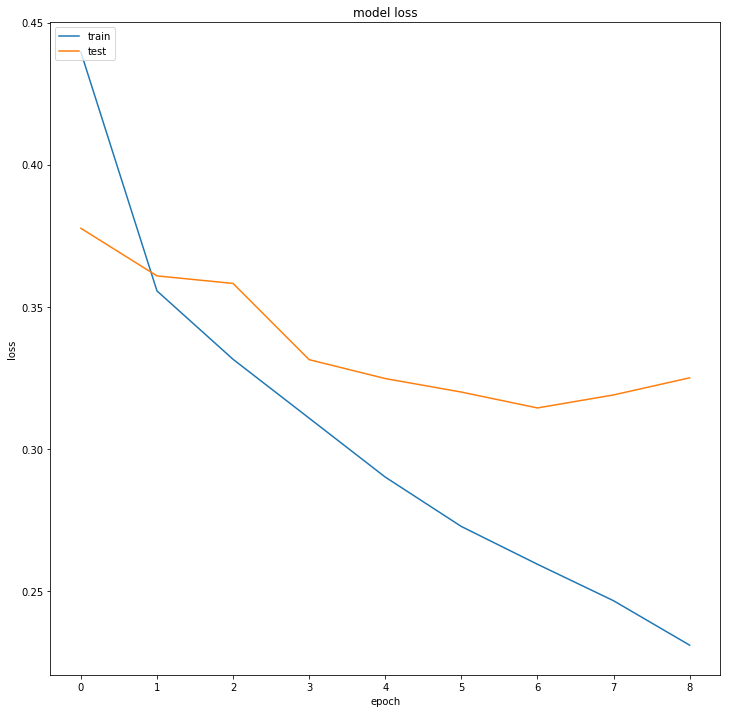

In [564]:
model_lstm = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_LSTM_model(10), 'not_simple_LSTM')),
])

model_lstm.fit(x_train, dummy_y_train)

plot_training(model_lstm.steps[1][1].history) 

In [565]:
get_accuracy_score(model_lstm)

0.8021828103683493

### Conv1d

Train on 16613 samples, validate on 4154 samples
Epoch 1/10
16613/16613 [==============================] - ETA: 9s - loss: 0.1694 - acc: 0.941 - ETA: 9s - loss: 0.1698 - acc: 0.938 - ETA: 9s - loss: 0.1795 - acc: 0.931 - ETA: 9s - loss: 0.1801 - acc: 0.933 - ETA: 9s - loss: 0.1850 - acc: 0.929 - ETA: 9s - loss: 0.1879 - acc: 0.928 - ETA: 8s - loss: 0.1890 - acc: 0.927 - ETA: 8s - loss: 0.1929 - acc: 0.925 - ETA: 8s - loss: 0.1923 - acc: 0.925 - ETA: 8s - loss: 0.1925 - acc: 0.924 - ETA: 8s - loss: 0.1937 - acc: 0.924 - ETA: 8s - loss: 0.1924 - acc: 0.924 - ETA: 8s - loss: 0.1901 - acc: 0.924 - ETA: 8s - loss: 0.1909 - acc: 0.923 - ETA: 8s - loss: 0.1948 - acc: 0.920 - ETA: 8s - loss: 0.1943 - acc: 0.921 - ETA: 8s - loss: 0.1959 - acc: 0.919 - ETA: 7s - loss: 0.1990 - acc: 0.917 - ETA: 7s - loss: 0.2008 - acc: 0.916 - ETA: 7s - loss: 0.1996 - acc: 0.917 - ETA: 7s - loss: 0.1993 - acc: 0.917 - ETA: 7s - loss: 0.1986 - acc: 0.917 - ETA: 7s - loss: 0.1993 - acc: 0.916 - ETA: 7s - loss: 0.1

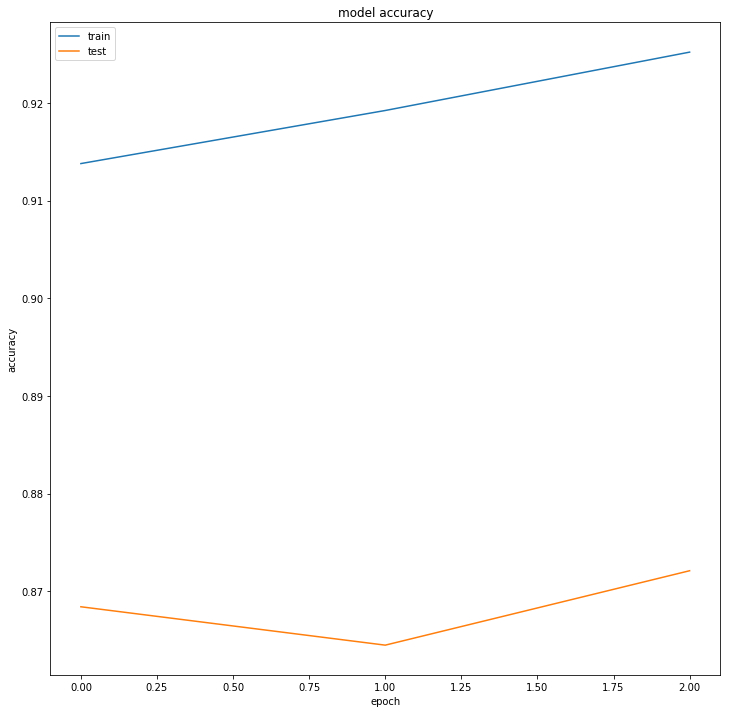

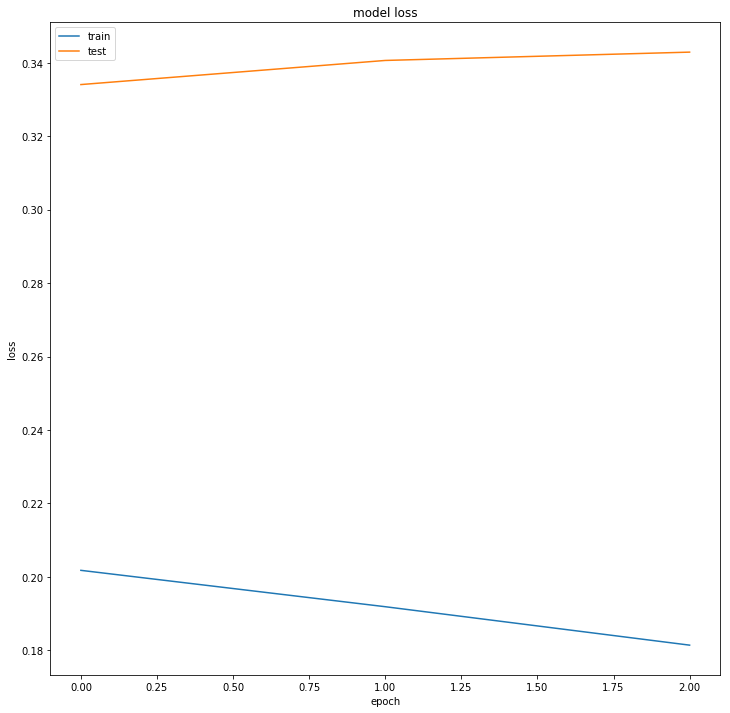

In [567]:
model_conv = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_conv_model(0.3, 10), 'conv_1d')),
])

model.fit(x_train, dummy_y_train)

plot_training(model.steps[1][1].history) 

In [568]:
get_accuracy_score(model_conv)

Lazy loading embeddings...


0.4120054570259209

### Jak wczytać dane do challenge'u?

In [293]:
scoring_set = pd.read_csv("./data/challenge_set_warsztat.csv", sep = ';')
scoring_set = TokenizedDataFrame(stopwords).transform(scoring_set, 'token')

### Jak stworzyć i zapisać predykcję?

In [572]:
# dla sklearn API
pred = model_lr.predict(scoring_set.token)

# dla Keras
pred = model.predict(scoring_set.token).argmax(axis=1)-1

In [573]:
assert len(pred) == 5022

### Wektor zapisany przez np.save należy przesłać do nas na e-mail

In [470]:
np.save('result', pred)